In [1]:
# !pip install kagglehub
# !pip install tensorflow
# !pip install scikit-learn
# !pip install scikit-image


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import precision_score

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


### 4.2

<Figure size 2000x800 with 0 Axes>

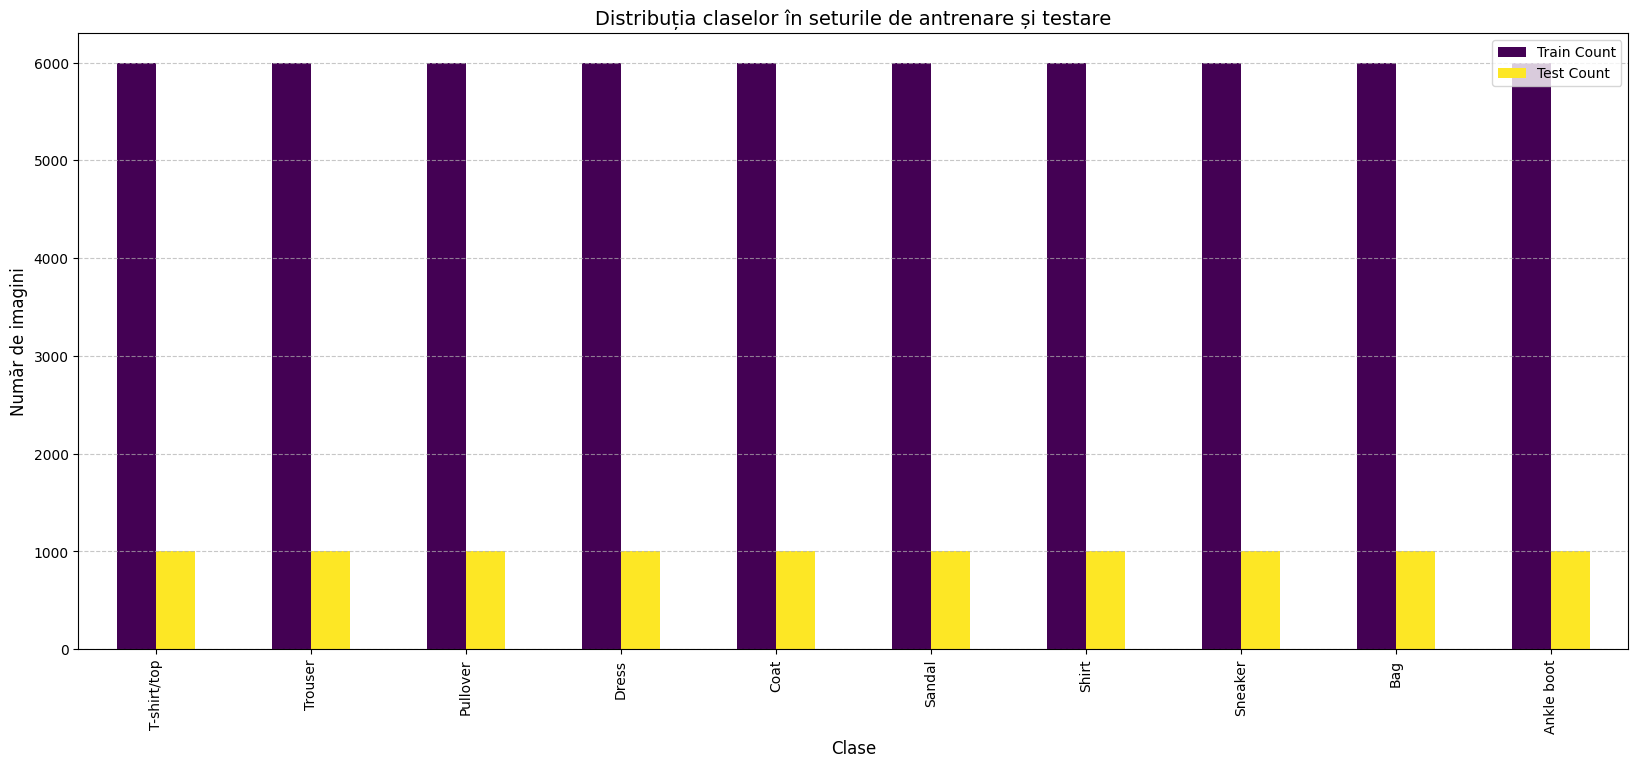

In [3]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

combined_df = pd.DataFrame({
    'Class': class_names,
    'Train Count': dict(zip(unique_train, counts_train)).values(),
    'Test Count': dict(zip(unique_test, counts_test)).values()
})

plt.figure(figsize=(20, 8))
combined_df.set_index('Class').plot(kind='bar', colormap='viridis', figsize=(20, 8))
plt.xticks(rotation=90, fontsize=10)
plt.title('Distribuția claselor în seturile de antrenare și testare', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Număr de imagini', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

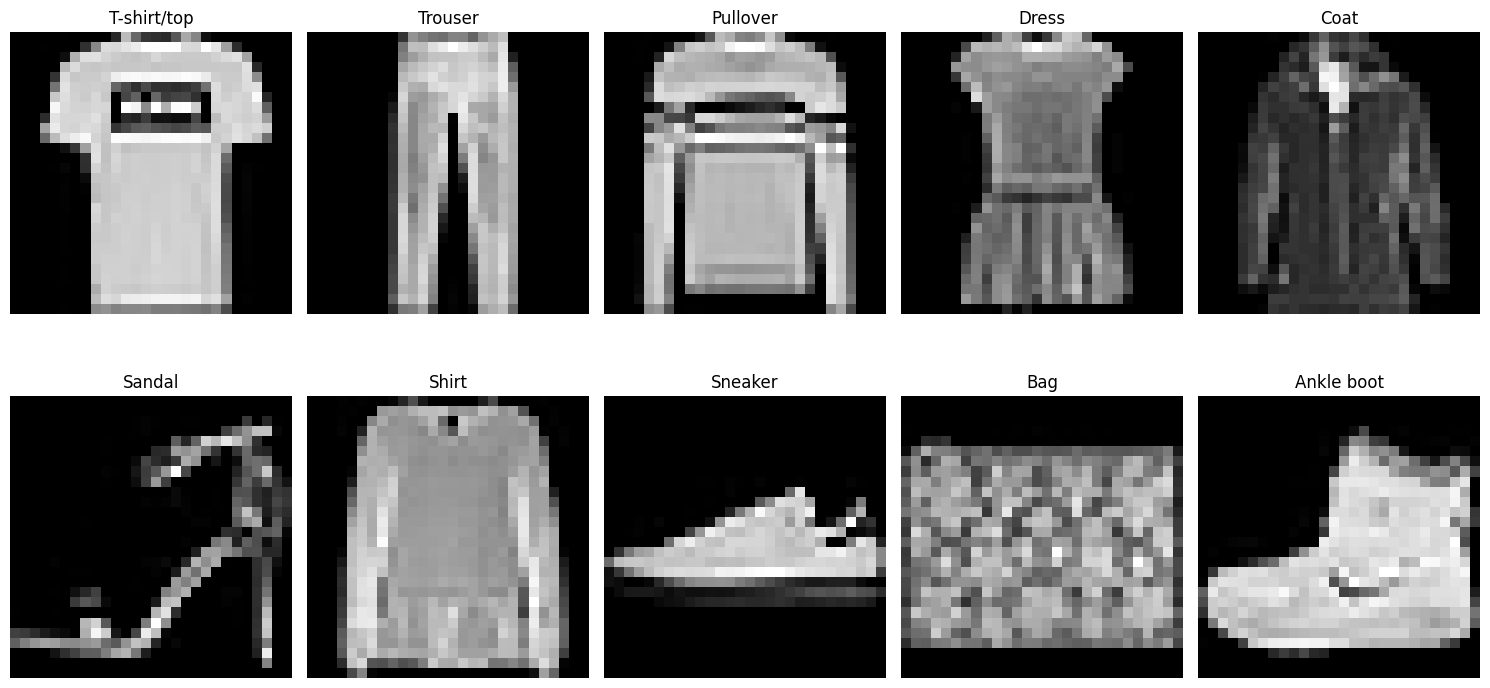

In [4]:
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    image_sample = x_train[y_train == i][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_sample, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

pca = PCA(n_components=25)
x_train_pca = pca.fit_transform(x_train_flat)
x_test_pca = pca.transform(x_test_flat)

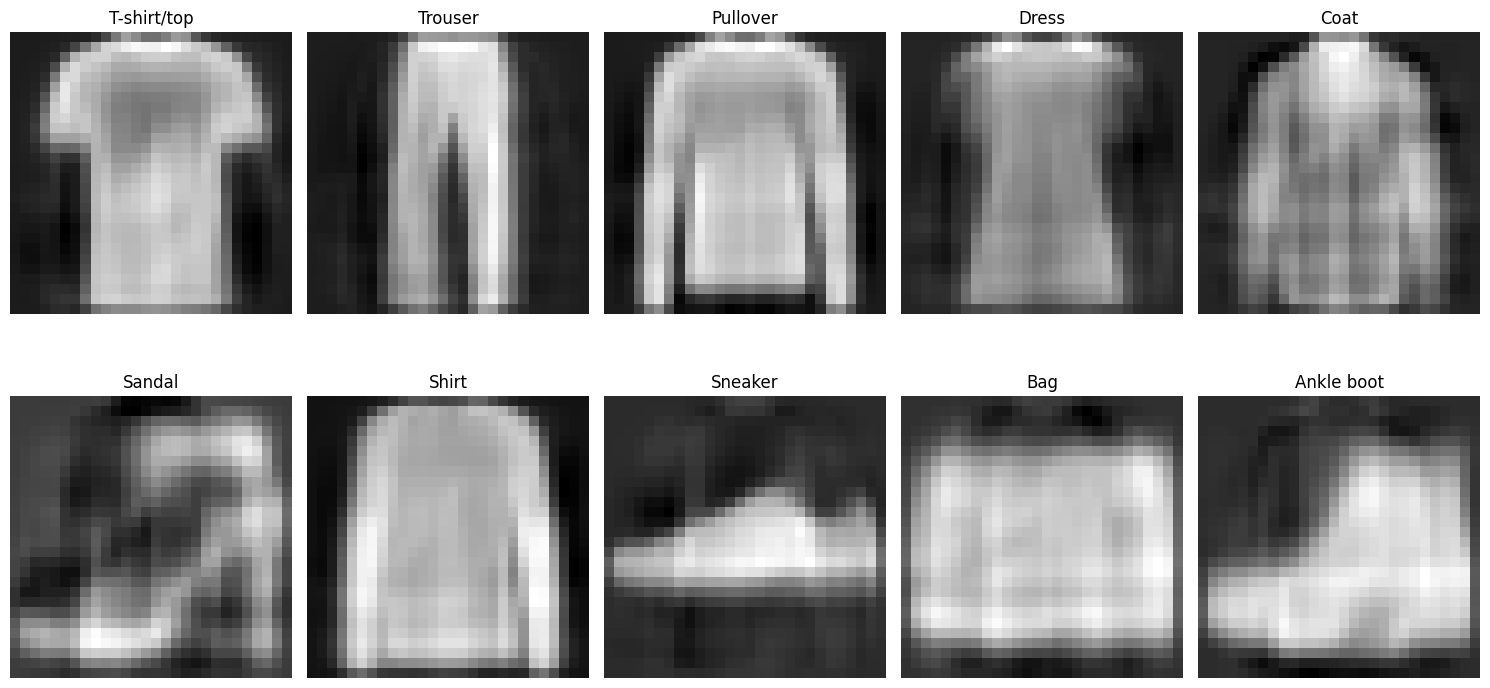

In [6]:
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    image_sample = x_train_pca[y_train == i][0]
    image_sample = pca.inverse_transform(image_sample).reshape(28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_sample, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

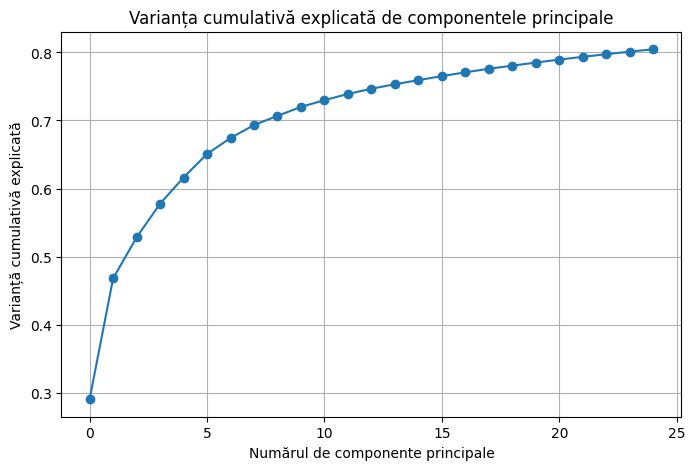

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Varianța cumulativă explicată de componentele principale")
plt.xlabel("Numărul de componente principale")
plt.ylabel("Varianță cumulativă explicată")
plt.grid()
plt.show()

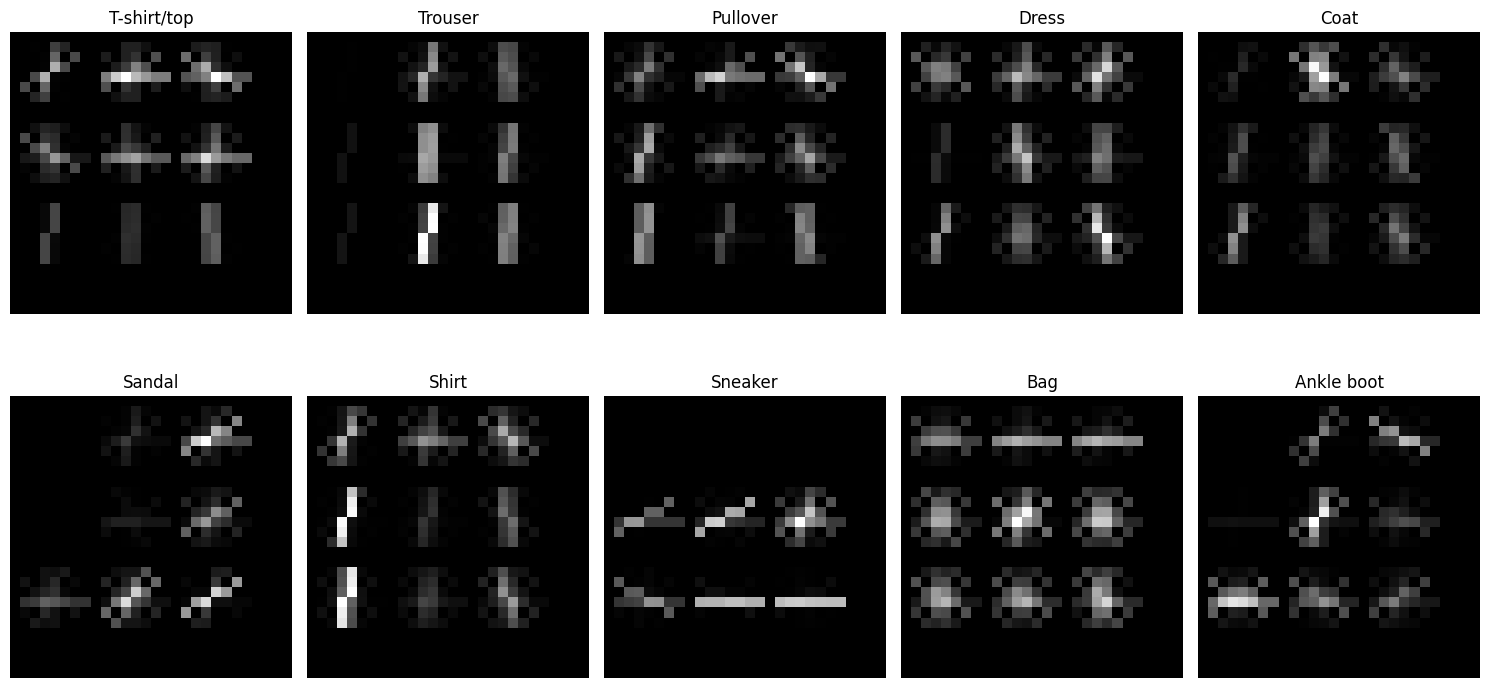

In [8]:


plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    image_sample = x_train[y_train == i][0]
    _, hog_image = hog(image_sample, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis=2)

    plt.subplot(2, 5, i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        feature, _= hog(img, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True, channel_axis=2)
        hog_features.append(feature)
    return np.array(hog_features)

hog_features_train = apply_hog_fixed(x_train)
hog_features_test = apply_hog_fixed(x_test)

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")




HOG Features Train Shape: (60000, 144)
HOG Features Test Shape: (10000, 144)


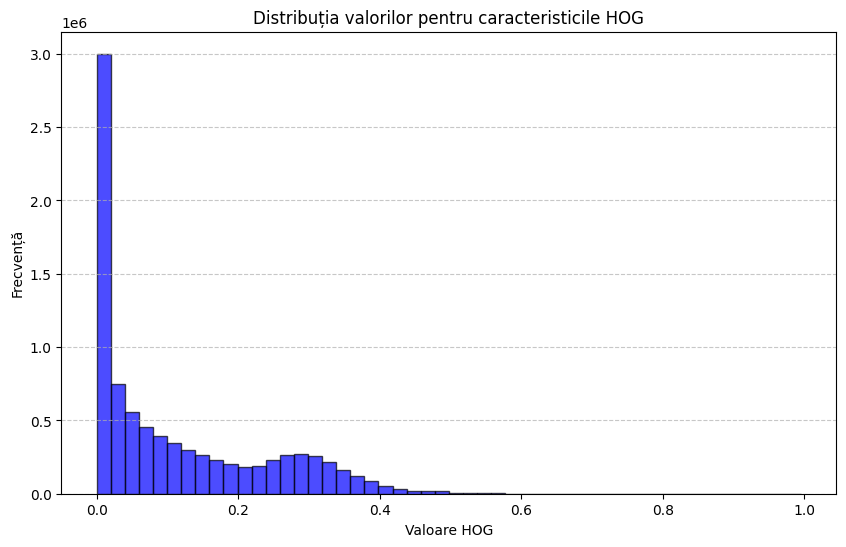

In [10]:
hog_feature_values = hog_features_train.flatten()

plt.figure(figsize=(10, 6))
plt.hist(hog_feature_values, bins=50, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribuția valorilor pentru caracteristicile HOG")
plt.xlabel("Valoare HOG")
plt.ylabel("Frecvență")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:


scaler = StandardScaler()

scaler.fit(x_train_pca)

x_train_pca_standardized = scaler.transform(x_train_pca)

x_test_pca_standardized = scaler.transform(x_test_pca)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(hog_features_train)
x_test_hog_standardized = scaler_hog.transform(hog_features_test)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

variance_threshold = VarianceThreshold(threshold=1)
x_train_variance = variance_threshold.fit_transform(x_train_combined)
x_test_variance = variance_threshold.transform(x_test_combined)

print("Dimensiuni înainte și după Variance Threshold:")
print(f"Dimensiuni train înainte: {x_train_combined.shape}, după: {x_train_variance.shape}")
print(f"Dimensiuni test înainte: {x_test_combined.shape}, după: {x_test_variance.shape}")


Dimensiuni înainte și după Variance Threshold:
Dimensiuni train înainte: (60000, 169), după: (60000, 94)
Dimensiuni test înainte: (10000, 169), după: (10000, 94)


## LogisticRegression

C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\raduf\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIM

Cei mai buni hiper-parametri: {'multi_class': 'multinomial', 'C': 1}
Accuracy (Combined PCA + HOG): 0.8357
Classification Report (Combined PCA + HOG):
              precision    recall  f1-score   support

 T-shirt/top       0.78      0.80      0.79      1000
     Trouser       0.97      0.95      0.96      1000
    Pullover       0.75      0.72      0.73      1000
       Dress       0.83      0.87      0.85      1000
        Coat       0.70      0.74      0.72      1000
      Sandal       0.95      0.92      0.93      1000
       Shirt       0.57      0.54      0.56      1000
     Sneaker       0.90      0.92      0.91      1000
         Bag       0.95      0.96      0.95      1000
  Ankle boot       0.93      0.94      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.83      0.84      0.84     10000
weighted avg       0.83      0.84      0.84     10000

Mean Precision: 0.8348101634512346
Variance of Precision: 0.015338221220105896


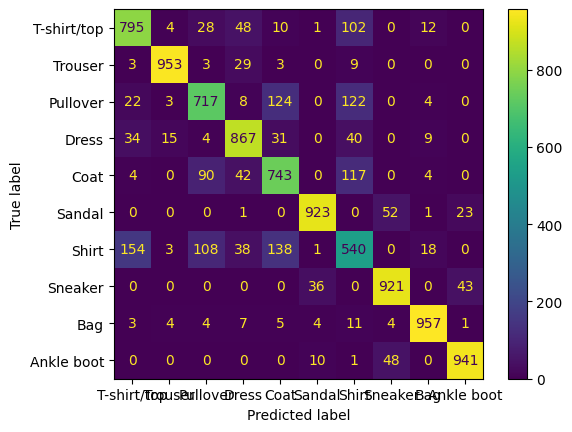

In [ ]:


log_reg = LogisticRegression(max_iter=150)

param_grid = {
    "C": [0.1, 1, 10, 100],
    "multi_class": ["ovr", "multinomial"] 
}


random_search = RandomizedSearchCV(log_reg, param_grid, cv=5, random_state=42)

random_search.fit(x_train_variance, y_train)

best_model = random_search.best_estimator_
best_params = random_search.best_params_

y_pred_combined = best_model.predict(x_test_variance)

accuracy_combined = accuracy_score(y_test, y_pred_combined)
report_combined = classification_report(y_test, y_pred_combined, target_names=class_names)

print(f"Cei mai buni hiper-parametri: {best_params}")
print(f"Accuracy (Combined PCA + HOG): {accuracy_combined}")
print("Classification Report (Combined PCA + HOG):")
print(report_combined)

ConfusionMatrixDisplay.from_estimator(best_model, x_test_variance, y_test, display_labels=class_names)

precision_scores = precision_score(y_test, y_pred_combined, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")


## SVM

In [ ]:
# # svm 59 de minute
import warnings
warnings.filterwarnings("ignore")
svm_model = SVC()

param_grid_svm = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'sigmoid']
    }

# parametrii pentru svm
# param_grid_svm = {
#         'C': [10],
#         'kernel': ['rbf']
#     }


random_search_svm = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_grid_svm,
    scoring="accuracy",
    cv=5,
    verbose=0,
    random_state=42
)

random_search_svm.fit(x_train_variance, y_train)

best_svm_model = random_search_svm.best_estimator_
best_svm_params = random_search_svm.best_params_

y_pred_svm = best_svm_model.predict(x_test_variance)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, target_names=class_names, digits=3)

print(f"Cei mai buni hiper-parametri SVM: {best_svm_params}")
print(f"Accuracy SVM (Combined PCA + HOG): {accuracy_svm}")
print("Classification Report SVM:")
print(report_svm)

ConfusionMatrixDisplay.from_estimator(best_svm_model, x_test_variance, y_test, display_labels=class_names)
precision_scores = precision_score(y_test, y_pred_svm, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")


## RandomForest

In [ ]:
# # 45 de minute
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'max_samples': [0.5, 0.75, 1.0]
}

random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid_rf,
    scoring="accuracy",
    cv=5,
    random_state=42
)

random_search_rf.fit(x_train_variance, y_train)

best_rf_model = random_search_rf.best_estimator_
best_rf_params = random_search_rf.best_params_

y_pred_rf = best_rf_model.predict(x_test_variance)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, target_names=class_names)

print(f"Cei mai buni hiper-parametri Random Forest: {best_rf_params}")
print(f"Accuracy Random Forest (Combined PCA + HOG): {accuracy_rf}")
print("Classification Report Random Forest:")
print(report_rf)

ConfusionMatrixDisplay.from_estimator(best_rf_model, x_test_variance, y_test, display_labels=class_names)
precision_scores = precision_score(y_test, y_pred_rf, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")


## GradientBoostingClassifier

[10:28:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:29:06] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:30:05] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false

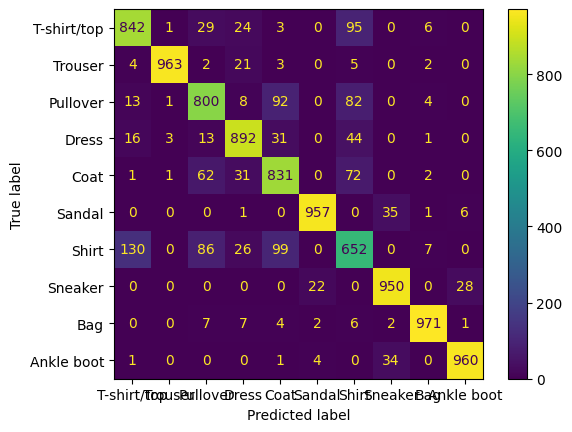

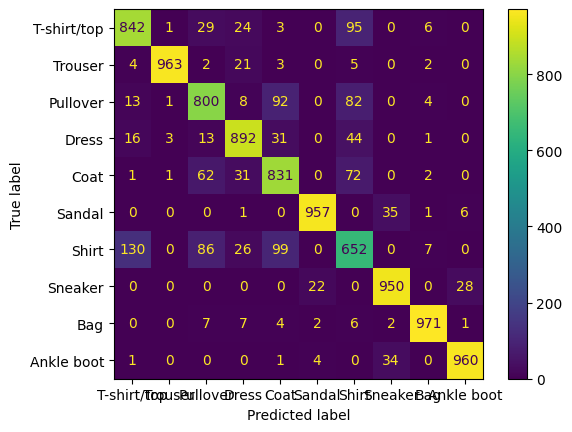

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42, eval_metric="logloss", tree_method="hist", device="cuda")

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid_xgb,
    scoring="accuracy",
    cv=5,
    random_state=42
)

random_search_xgb.fit(x_train_variance, y_train)

best_xgb_model = random_search_xgb.best_estimator_
best_xgb_params = random_search_xgb.best_params_

y_pred_xgb = best_xgb_model.predict(x_test_variance)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb, target_names=class_names)

print(f"Cei mai buni hiper-parametri XGBClassifier: {best_xgb_params}")
print(f"Accuracy XGBClassifier: {accuracy_xgb}")
print("Classification Report XGBClassifier:")
print(report_xgb)

ConfusionMatrixDisplay.from_estimator(best_xgb_model, x_test_variance, y_test, display_labels=class_names)
precision_scores = precision_score(y_test, y_pred_xgb, average=None)
mean_precision = np.mean(precision_scores)
var_precision = np.var(precision_scores)

print(f"Mean Precision: {mean_precision}")
print(f"Variance of Precision: {var_precision}")